# Fianl squib

This notebook computes **pairwise inter-annotator agreement (IAA)** using **Cohen’s κ** for:

- **Partner 1 vs Partner 2** (human–human)
- **Partner 1 vs Assistant label** (human–assistant)
- **Partner 2 vs Assistant label** (human–assistant)

It also produces **confusion matrices** and supports **error analysis**.

**Input file:** `shared_memory_for_labeling.xlsx`


In [2]:
!pip install openpyxl



   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpy


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
import pandas as pd
import numpy as np

from sklearn.metrics import cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

FILE_PATH = "shared_memory_for_labeling.xlsx"
df = pd.read_excel(FILE_PATH)
print("Loaded:", FILE_PATH)
print("Rows, Cols:", df.shape)
df.head()


Loaded: shared_memory_for_labeling.xlsx
Rows, Cols: (24, 6)


,Block+A1:B6 #,Turns,Label partner 1,Notes,Label partner 2,Label (Assistant)
0,1,Manar: Yeah man you(.) do you remember like th...,Memory Reference,NaN,Memory Reference,Memory Reference
1,2,"Raihan: Its been what so long,?↑two years now:...",Evaluative Expression,NaN,Evaluative Expression,Evaluative Expression
2,3,"Raihan: =More.\nManar: Two and halve years, so...",Incremental Addition,NaN,Incremental Addition,Incremental Addition
3,4,Manar: =Maybe.\nRaihan: Even during the dinant...,Evaluative Expression,NaN,Evaluative Expression,Evaluative Expression
4,5,Raihan: ah\nRaihan: the germany one\nRaihan: w...,Evaluative Expression,I was hestitating between memory refrence and ...,Memory Reference,Memory Reference


## 1) Set column names

Run the next cell to see the columns, then set the three variables.


In [32]:
list(df.columns)


['Block+A1:B6 #',
 'Turns ',
 'Label partner 1',
 'Notes',
 'Label partner 2',
 'Label (Assistant)']

In [47]:
PARTNER_1_COL = "Label partner 1"
PARTNER_2_COL = "Label partner 2"
ASSISTANT_COL = "Label (Assistant)"

for col in [PARTNER_1_COL, PARTNER_2_COL, ASSISTANT_COL]:
    assert col in df.columns, f"Column not found: {col}"


## 2) Clean labels + create pairwise datasets


In [48]:
def clean_series(s: pd.Series) -> pd.Series:
    return s.astype(str).str.strip()

df_pair_p1_p2 = df[[PARTNER_1_COL, PARTNER_2_COL] + ([TEXT_COL] if TEXT_COL else [])].dropna(subset=[PARTNER_1_COL, PARTNER_2_COL]).copy()
df_pair_p1_asst = df[[PARTNER_1_COL, ASSISTANT_COL] + ([TEXT_COL] if TEXT_COL else [])].dropna(subset=[PARTNER_1_COL, ASSISTANT_COL]).copy()
df_pair_p2_asst = df[[PARTNER_2_COL, ASSISTANT_COL] + ([TEXT_COL] if TEXT_COL else [])].dropna(subset=[PARTNER_2_COL, ASSISTANT_COL]).copy()

df_pair_p1_p2[PARTNER_1_COL] = clean_series(df_pair_p1_p2[PARTNER_1_COL])
df_pair_p1_p2[PARTNER_2_COL] = clean_series(df_pair_p1_p2[PARTNER_2_COL])

df_pair_p1_asst[PARTNER_1_COL] = clean_series(df_pair_p1_asst[PARTNER_1_COL])
df_pair_p1_asst[ASSISTANT_COL] = clean_series(df_pair_p1_asst[ASSISTANT_COL])

df_pair_p2_asst[PARTNER_2_COL] = clean_series(df_pair_p2_asst[PARTNER_2_COL])
df_pair_p2_asst[ASSISTANT_COL] = clean_series(df_pair_p2_asst[ASSISTANT_COL])

print("Rows with both labels:")
print("- Partner 1 vs Partner 2:", len(df_pair_p1_p2))
print("- Partner 1 vs Assistant:", len(df_pair_p1_asst))
print("- Partner 2 vs Assistant:", len(df_pair_p2_asst))


Rows with both labels:
- Partner 1 vs Partner 2: 24
- Partner 1 vs Assistant: 24
- Partner 2 vs Assistant: 24


## 3) Cohen’s κ (pairwise)


In [49]:
kappa_p1_p2 = cohen_kappa_score(df_pair_p1_p2[PARTNER_1_COL], df_pair_p1_p2[PARTNER_2_COL])
kappa_p1_asst = cohen_kappa_score(df_pair_p1_asst[PARTNER_1_COL], df_pair_p1_asst[ASSISTANT_COL])
kappa_p2_asst = cohen_kappa_score(df_pair_p2_asst[PARTNER_2_COL], df_pair_p2_asst[ASSISTANT_COL])

print("Cohen’s κ scores:")
print("------------------")
print(f"Partner 1 vs Partner 2 : {kappa_p1_p2:.3f}")
print(f"Partner 1 vs Assistant : {kappa_p1_asst:.3f}")
print(f"Partner 2 vs Assistant : {kappa_p2_asst:.3f}")


Cohen’s κ scores:
------------------
Partner 1 vs Partner 2 : 0.826
Partner 1 vs Assistant : 0.650
Partner 2 vs Assistant : 0.766


## 4) Confusion matrices

We generate confusion matrices for:
- **Partner 1 vs Partner 2**
- **Partner 2 vs Assistant**


In [36]:
# Union of labels across all annotators (for consistent axes)
all_labels = set(df_pair_p1_p2[PARTNER_1_COL]) | set(df_pair_p1_p2[PARTNER_2_COL]) | \
            set(df_pair_p2_asst[PARTNER_2_COL]) | set(df_pair_p2_asst[ASSISTANT_COL])
labels = sorted(all_labels)
labels


['Affiliative Response',
 'Evaluative Expression',
 'Incremental Addition',
 'Memory Reference']

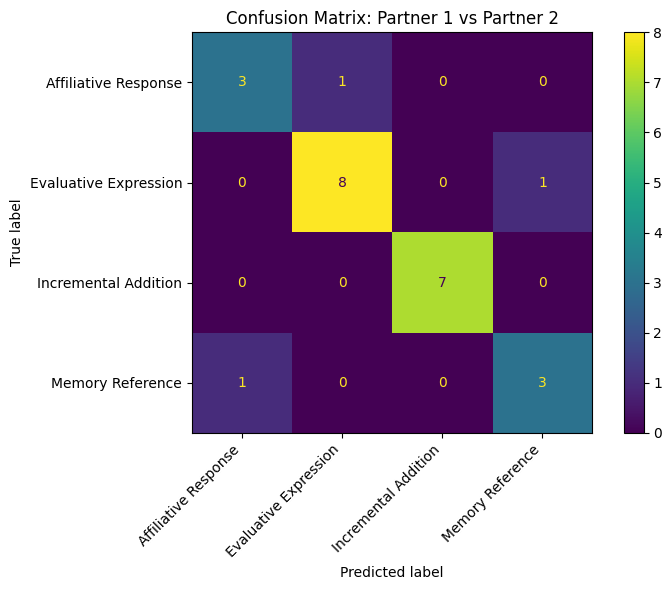

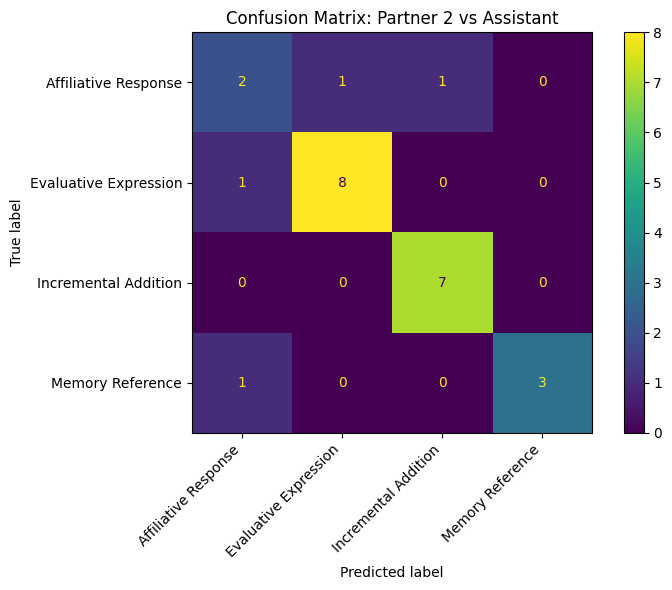

In [37]:
def show_confusion(a, b, title):
    cm = confusion_matrix(a, b, labels=labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(ax=ax, values_format='d')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    return cm

cm_p1_p2 = show_confusion(
    df_pair_p1_p2[PARTNER_1_COL],
    df_pair_p1_p2[PARTNER_2_COL],
    "Confusion Matrix: Partner 1 vs Partner 2"
)

cm_p2_asst = show_confusion(
    df_pair_p2_asst[PARTNER_2_COL],
    df_pair_p2_asst[ASSISTANT_COL],
    "Confusion Matrix: Partner 2 vs Assistant"
)


## 5) Error analysis

### 5a) Most frequent disagreements


In [38]:
def disagreement_table(df_pair, col_a, col_b):
    disagree = df_pair[df_pair[col_a] != df_pair[col_b]].copy()
    pairs = (
        disagree.groupby([col_a, col_b]).size().reset_index(name='count')
        .sort_values('count', ascending=False)
    )
    return disagree, pairs

disagree_p1_p2, pairs_p1_p2 = disagreement_table(df_pair_p1_p2, PARTNER_1_COL, PARTNER_2_COL)
disagree_p2_asst, pairs_p2_asst = disagreement_table(df_pair_p2_asst, PARTNER_2_COL, ASSISTANT_COL)

print("Partner 1 vs Partner 2 — disagreements:", len(disagree_p1_p2))
display(pairs_p1_p2.head(15))

print("Partner 2 vs Assistant — disagreements:", len(disagree_p2_asst))
display(pairs_p2_asst.head(15))


Partner 1 vs Partner 2 — disagreements: 3


,Label partner 1,Label partner 2,count
0,Affiliative Response,Evaluative Expression,1
1,Evaluative Expression,Memory Reference,1
2,Memory Reference,Affiliative Response,1


Partner 2 vs Assistant — disagreements: 4


,Label partner 2,Label (Assistant),count
0,Affiliative Response,Evaluative Expression,1
1,Affiliative Response,Incremental Addition,1
2,Evaluative Expression,Affiliative Response,1
3,Memory Reference,Affiliative Response,1


## 6) Optional exports


In [40]:
pd.DataFrame(cm_p1_p2, index=labels, columns=labels).to_csv("cm_partner1_partner2.csv")
pd.DataFrame(cm_p2_asst, index=labels, columns=labels).to_csv("cm_partner2_assistant.csv")
pairs_p1_p2.to_csv("top_disagreements_partner1_partner2.csv", index=False)
pairs_p2_asst.to_csv("top_disagreements_partner2_assistant.csv", index=False)

if TEXT_COL:
    disagree_p1_p2[[TEXT_COL, PARTNER_1_COL, PARTNER_2_COL]].to_csv("disagreement_examples_partner1_partner2.csv", index=False)
    disagree_p2_asst[[TEXT_COL, PARTNER_2_COL, ASSISTANT_COL]].to_csv("disagreement_examples_partner2_assistant.csv", index=False)

print("Saved CSV outputs.")


Saved CSV outputs.
